# Deteccion de fraude en tarjetas de credito con redes neuronales

## Imports

In [71]:
import sys;
assert sys.version_info >= (3, 5);
import sklearn;
assert sklearn.__version__ >= "0.20";
import numpy as np;
import math;
import os;
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
from scipy import stats;
from scipy.stats import norm;
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Carga de datos

In [72]:
# dataset from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv(filepath_or_buffer="dataset/creditcard_sin_outliers.csv")
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Borrar lo sobrante

In [73]:
df = df.drop(['Time'], axis=1)
df = df.drop(['Amount'], axis=1)

## Generacion de datos para aumentar la cantidad de positivos

In [74]:
of_dataset = '% of the dataset'
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), of_dataset)
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), of_dataset)

No Frauds 99.78 % of the dataset
Frauds 0.22 % of the dataset


Como hay muy pocos datos de fraude, se generan datos sinteticos para aumentar la cantidad de positivos
y mejorar el entrenamiento de la red neuronal.

In [75]:
fraudes = df[df['Class'] == 1].copy()
no_fraudes = df[df['Class'] == 0].copy()

no_fraudes = sklearn.utils.shuffle(no_fraudes)
no_fraudes = no_fraudes.sample(len(fraudes)*10)
df2 = pd.concat([fraudes, no_fraudes], axis=0)
df2 = sklearn.utils.shuffle(df2)


In [76]:
print('No Frauds', round(df2['Class'].value_counts()[0]/len(df2) * 100,2), '% of the dataset')
print('Frauds', round(df2['Class'].value_counts()[1]/len(df2) * 100,2), '% of the dataset')

No Frauds 90.91 % of the dataset
Frauds 9.09 % of the dataset


In [77]:
df2.shape

(5412, 29)

## Separacion de datos de entrenamiento y test

In [78]:
# make x_train and y_train a 80% of the dataset and test 20%
x_train = df2.iloc[:int(len(df2)*0.8), :-1]
y_train = df2.iloc[:int(len(df2)*0.8), -1]
x_val = df2.iloc[int(len(df2)*0.8):int(len(df2)*0.9), :-1]
y_val = df2.iloc[int(len(df2)*0.8):int(len(df2)*0.9), -1]
x_test = df2.iloc[int(len(df2)*0.9):, :-1]
y_test = df2.iloc[int(len(df2)*0.9):, -1]

## Creacion de la red neuronal

In [79]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()
model.add(Dense(28, activation='sigmoid', input_shape=(28,)))
model.add(Dense(10, activation='sigmoid', input_shape=(29,)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                290       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 1,113
Trainable params: 1,113
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento

In [80]:
model.compile(loss="binary_crossentropy", optimizer="sgd",metrics = ['accuracy'])

In [85]:
model.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=50, epochs=50)

Train on 4329 samples, validate on 541 samples
Epoch 1/50
4329/4329 [==============================] - 0s 21us/step - loss: 0.1438 - accuracy: 0.9420 - val_loss: 0.1370 - val_accuracy: 0.9575
Epoch 2/50
4329/4329 [==============================] - 0s 27us/step - loss: 0.1411 - accuracy: 0.9496 - val_loss: 0.1348 - val_accuracy: 0.9612
Epoch 3/50
4329/4329 [==============================] - 0s 17us/step - loss: 0.1385 - accuracy: 0.9540 - val_loss: 0.1327 - val_accuracy: 0.9649
Epoch 4/50
4329/4329 [==============================] - 0s 18us/step - loss: 0.1360 - accuracy: 0.9573 - val_loss: 0.1306 - val_accuracy: 0.9686
Epoch 5/50
4329/4329 [==============================] - 0s 16us/step - loss: 0.1335 - accuracy: 0.9658 - val_loss: 0.1286 - val_accuracy: 0.9778
Epoch 6/50
4329/4329 [==============================] - 0s 16us/step - loss: 0.1311 - accuracy: 0.9730 - val_loss: 0.1267 - val_accuracy: 0.9778
Epoch 7/50
4329/4329 [==============================] - 0s 17us/step - loss: 0.1288

In [86]:
test_loss, test_acc = model.evaluate(x_test, y_test)

542/542 [==============================] - 0s 24us/step


In [87]:
from sklearn.metrics import confusion_matrix
import numpy as np
predictions = model.predict(x_test)

Y_pred_classes = []
for pred in predictions:
    if pred > 0.5:
        Y_pred_classes.append(1)
    else:
        Y_pred_classes.append(0)
Y_pred_classes = np.array(Y_pred_classes)
Y_true = y_test.values 
print(Y_true)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx

confusion_mtx_without_diagonal = confusion_mtx.copy()
np.fill_diagonal(confusion_mtx_without_diagonal, 0)

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 

c:\Users\brais.fernandezvazqu\Miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
c:\Users\brais.fernandezvazqu\Miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


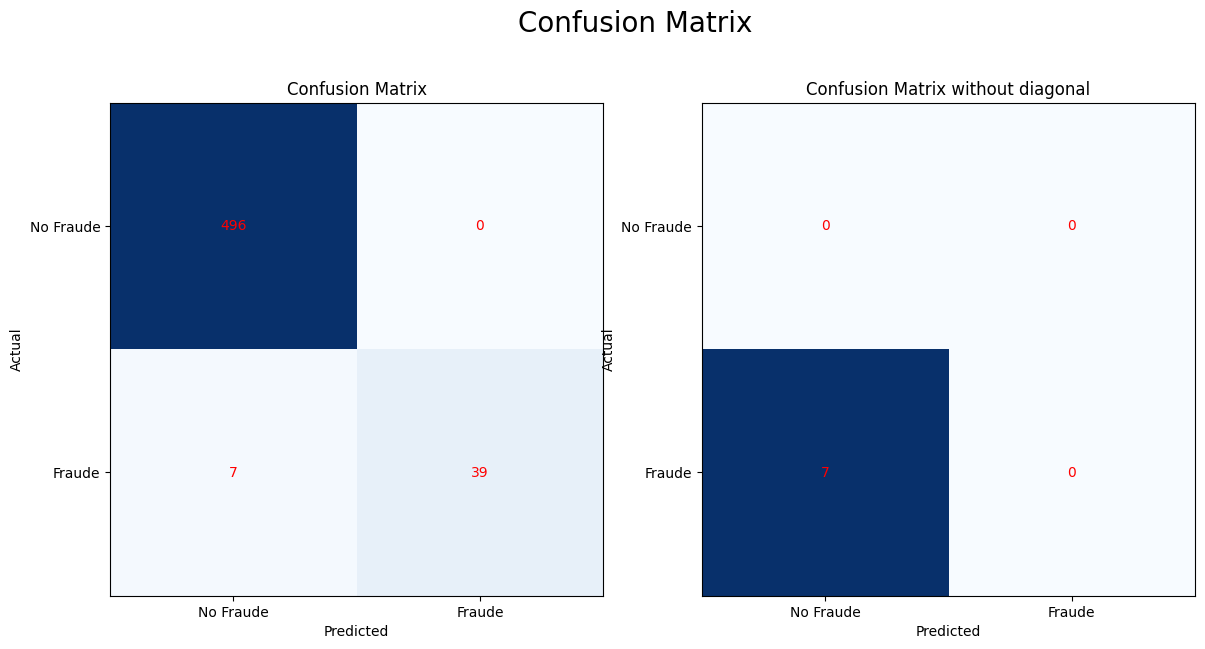

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
# set size of the figure
fig.set_size_inches(14, 7)
# set title of the figure
fig.suptitle('Confusion Matrix', fontsize=20)
# plot the confusion matrix
ax[0].set_title('Confusion Matrix')
ax[0].imshow(confusion_mtx, cmap='Blues')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['No Fraude', 'Fraude'])
ax[0].set_yticklabels(['No Fraude', 'Fraude'])
ax[0].set_yticks([0,1])
# print numbers in the confusion matrix
for i in range(2):
    for j in range(2):
        ax[0].text(j, i, confusion_mtx[i, j], ha="center", va="center", color="r")

ax[1].set_title('Confusion Matrix without diagonal')
ax[1].imshow(confusion_mtx_without_diagonal, cmap='Blues')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['No Fraude', 'Fraude'])
ax[1].set_yticklabels(['No Fraude', 'Fraude'])
ax[1].set_yticks([0,1])
# print numbers in the confusion matrix
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, confusion_mtx_without_diagonal[i, j], ha="center", va="center", color="r")